# CASA I/O: Combining data from multiple observations

#### WARNING: Tutorial under construction

In [1]:
%load_ext autoreload
%autoreload 2

## Import to Python

In [6]:
from casatools import msmetadata
from casatasks import uvcontsub, cvel, listobs
import casatools
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from astropy.constants import c

In [7]:
path = "/home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub"
path = "/home/darthbarth/Big_red/NGC4697/NGC4697_bary_phaseshifted_10kms.ms.split.cal.contsub"

In [8]:
msmd = casatools.msmetadata()
ms = casatools.ms()

In [9]:
msmd.open(path)
spws = msmd.datadescids() 
msmd.done()
print(spws)

[0 1]


### SPW 0 (low res)

In [10]:
ms.open(path)
# select the spectral window
ms.selectinit(datadescid=0)
query = ms.getdata(["WEIGHT", "UVW", "ANTENNA1", "ANTENNA2", "WEIGHT", "FLAG", "FLAG_ROW", "DATA", "AXIS_INFO"])
ant1 = query["antenna1"]
ant2 = query["antenna2"]
uvw = query["uvw"]
weight = query["weight"]
flag = query["flag"]
flag_rows = query["flag_row"]
data = query["data"]
info = query["axis_info"]
# always a good idea to reset the earmarked data
ms.selectinit(reset=True)
ms.close()

True

In [11]:
chan_freq = info["freq_axis"]["chan_freq"]
chan_freq = chan_freq.flatten()  # Hz
nchan = len(chan_freq)

In [12]:
np.sum(flag)

1231200

In [13]:
np.sum(flag_rows)

7695

In [14]:
flag = np.logical_or(flag, flag_rows[None, None, :])   # (npol, nchan, nvis)

#### Remove autocorrelations

In [46]:
xc = np.where(ant1 != ant2)[0]
data = data[:, :, xc]
flag = flag[:, :, xc]
uvw = uvw[:, xc]
weight = weight[:, xc]

#### Average polarizations

In [47]:
data = np.sum(data * weight[:, np.newaxis, :], axis=0) / np.sum(weight, axis=0)
flag = np.any(flag, axis=0)
weight = np.sum(weight, axis=0)

#### Mask

In [48]:
# when indexed with mask, returns valid visibilities
mask = ~flag

#### Reshaping

In [49]:
uu, vv, ww = uvw  # unpack into len nvis vectors
# broadcast to the same shape as the data
# stub to broadcast uu,vv, and weights to all channels
broadcast = np.ones((nchan, 1))
uu = uu * broadcast
vv = vv * broadcast
weight = weight * broadcast

In [50]:
from astropy.constants import c
max_uv_coord = np.max((np.max(np.abs(vv)), np.max(np.abs(uu))))
npix = 501
fov_arcseconds = 206265*npix/(2*max_uv_coord)

lam_hr   = c.value / chan_freq[:, None]              # (nchan,1)
w_lam_hr = (ww * np.ones((nchan,1))) / lam_hr        # (nchan, nvis)
w_rms    = np.sqrt(np.mean(w_lam_hr**2))

theta = (fov_arcseconds*np.pi/648000.0) / 2.0           # half-FoV in radians
print("w_rms * theta^2 ≈", float(w_rms * theta**2))

w_rms * theta^2 ≈ 1582.0840413108156


#### Convert uu and vv to lambda, frequencies to GHz

In [51]:
# calculate wavelengths in meters
wavelengths = c.value / chan_freq[:, np.newaxis]  # m

# calculate baselines in lambda
uu = uu / wavelengths  # [lambda]
vv = vv / wavelengths  # [lambda]

frequencies = chan_freq * 1e-9  # [GHz]

Text(0, 0.5, '$v$ [m]')

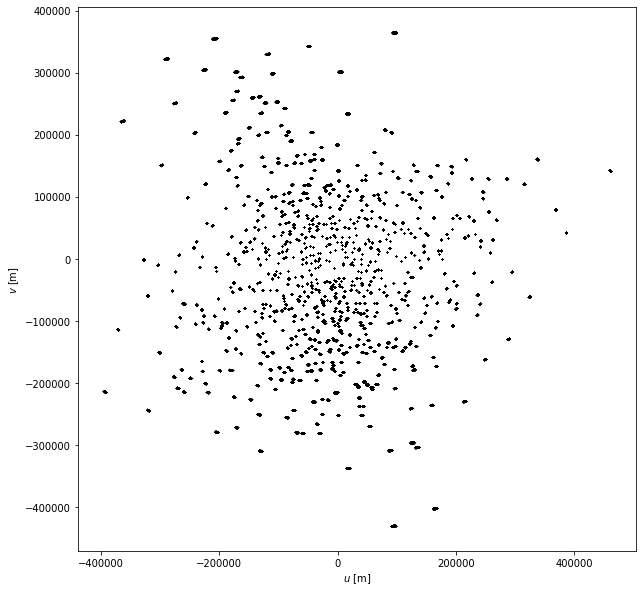

In [52]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, figsize=(10, 10))
ax.scatter(uu[::5], vv[::5], s=1.5, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [m]")
ax.set_ylabel(r"$v$ [m]")

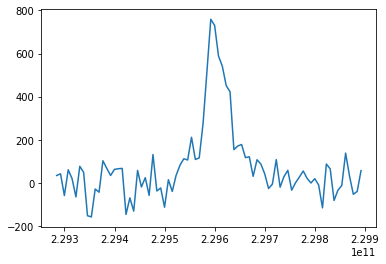

In [53]:
plt.plot(chan_freq, np.sum(data.real, axis = 1))

In [42]:
# save data to numpy file for later use
np.savez(
    "/home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_visibilities_low_res_test_flagged_rows.npz",
    frequencies=chan_freq,  # [Hz]
    uu=uu,  # lambda]
    vv=vv,  # [lambda]
    weight=weight,  # [1/Jy^2]
    data=data,  # [Jy]
    mask=mask,  # [Bool]
)

### SPW 1 (high res data)

In [54]:
ms.open(path)
# select the spectral window
ms.selectinit(datadescid=1)
query = ms.getdata(["WEIGHT", "UVW", "ANTENNA1", "ANTENNA2", "WEIGHT", "FLAG", "FLAG_ROW", "DATA", "AXIS_INFO"])
ant1_hr = query["antenna1"]
ant2_hr = query["antenna2"]
uvw_hr = query["uvw"]
weight_hr = query["weight"]
flag_hr = query["flag"]
flag_rows_hr = query["flag_row"]
data_hr = query["data"]
info_hr = query["axis_info"]
# always a good idea to reset the earmarked data
ms.selectinit(reset=True)
ms.close()

True

In [55]:
chan_freq_hr = info_hr["freq_axis"]["chan_freq"]
chan_freq_hr = chan_freq_hr.flatten()  # Hz
nchan = len(chan_freq_hr)

In [56]:
flag_hr = np.logical_or(flag_hr, flag_rows_hr[None, None, :])   # (npol, nchan, nvis)

#### Remove autocorrelations

In [57]:
xc = np.where(ant1_hr != ant2_hr)[0]
data_hr = data_hr[:, :, xc]
flag_hr = flag_hr[:, :, xc]
uvw_hr = uvw_hr[:, xc]
weight_hr = weight_hr[:, xc]

#### Average polarizations

In [58]:
data_hr = np.sum(data_hr * weight_hr[:, np.newaxis, :], axis=0) / np.sum(weight_hr, axis=0)
flag_hr = np.any(flag_hr, axis=0)
weight_hr = np.sum(weight_hr, axis=0)

#### Mask

In [59]:
# when indexed with mask, returns valid visibilities
mask_hr = ~flag_hr

#### Reshaping

In [60]:
uu_hr, vv_hr, ww_hr = uvw_hr  # unpack into len nvis vectors
# broadcast to the same shape as the data
# stub to broadcast uu,vv, and weights to all channels
broadcast = np.ones((nchan, 1))
uu_hr = uu_hr * broadcast
vv_hr = vv_hr * broadcast
weight_hr = weight_hr * broadcast

In [61]:
from astropy.constants import c
max_uv_coord = np.max((np.max(np.abs(vv_hr)), np.max(np.abs(uu_hr))))
npix = 301
fov_arcseconds = 206265*npix/(2*max_uv_coord)

lam_hr   = c.value / chan_freq_hr[:, None]              # (nchan,1)
w_lam_hr = (ww_hr * np.ones((nchan,1))) / lam_hr        # (nchan, nvis)
w_rms    = np.sqrt(np.mean(w_lam_hr**2))

theta = (fov_arcseconds*np.pi/648000.0) / 2.0           # half-FoV in radians
print("w_rms * theta^2 ≈", float(w_rms * theta**2))

w_rms * theta^2 ≈ 128.14822419181672


#### Convert uu and vv to lambda, frequencies to GHz

In [62]:
# calculate wavelengths in meters
wavelengths_hr = c.value / chan_freq_hr[:, np.newaxis]  # m

# calculate baselines in lambda
uu_hr = uu_hr / wavelengths_hr  # [lambda]
vv_hr = vv_hr / wavelengths_hr  # [lambda]

frequencies_hr = chan_freq_hr * 1e-9  # [GHz]

Text(0, 0.5, '$v$ [m]')

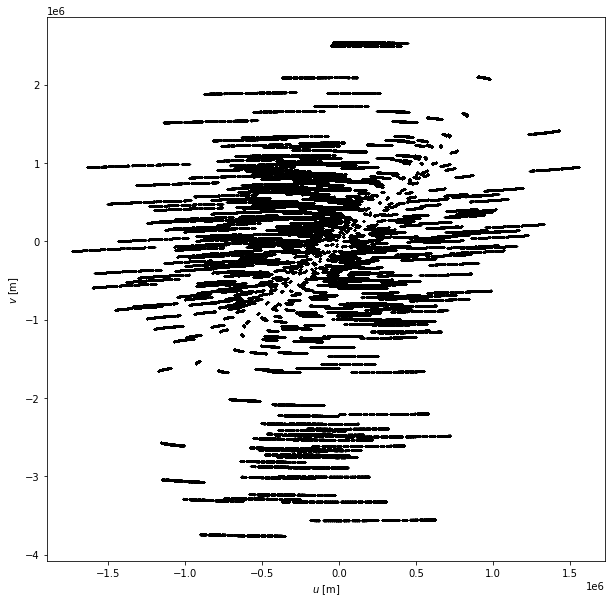

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, figsize=(10, 10))
ax.scatter(uu_hr[::5], vv_hr[::5], s=1.5, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [m]")
ax.set_ylabel(r"$v$ [m]")

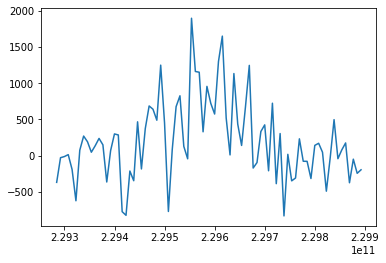

In [64]:
plt.plot(chan_freq_hr, np.sum(data_hr.real, axis = 1))

## Matching frequency order

In [30]:
#chan_freq_hr[::-1]

In [68]:
chan_freq_hr = chan_freq_hr[::-1]
uu_hr=uu_hr[::-1]
vv_hr=vv_hr[::-1]
weight_hr=weight_hr[::-1]
data_hr=data_hr[::-1]
mask_hr=mask_hr[::-1]

In [64]:
np.savez(
    "/home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_visibilities_high_res_test_flagged_rows.npz",
    frequencies=chan_freq_hr,  # [Hz]
    uu=uu_hr,  # lambda]
    vv=vv_hr,  # [lambda]
    weight=weight_hr,  # [1/Jy^2]
    data=data_hr,  # [Jy]
    mask=mask_hr,  # [Bool]
)

### Concatenating low and high res data

In [69]:
uu_combined = np.concatenate((uu, uu_hr), axis = 1)
vv_combined = np.concatenate((vv, vv_hr), axis = 1)
weight_combined = np.concatenate((weight, weight_hr), axis = 1)
data_combined = np.concatenate((data, data_hr), axis = 1)
mask_combined = np.concatenate((mask, mask_hr), axis = 1)

Text(0, 0.5, '$v$ [m]')

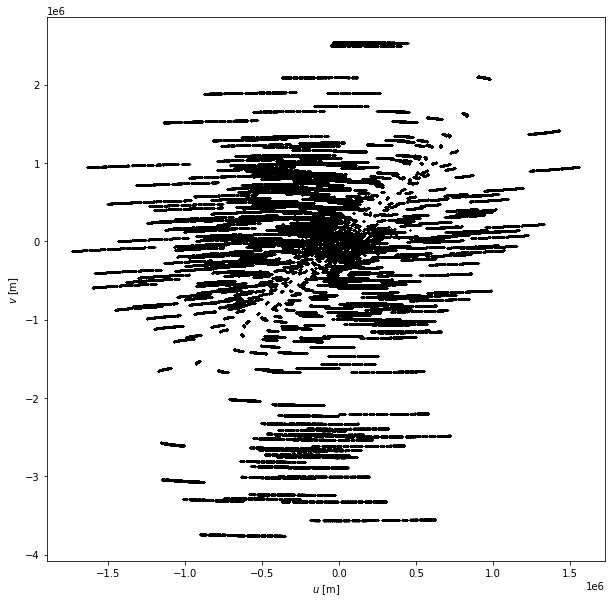

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, figsize=(10, 10))
ax.scatter(uu_combined[::5], vv_combined[::5], s=1.5, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [m]")
ax.set_ylabel(r"$v$ [m]")

### Saving data

In [71]:
# save data to numpy file for later use
np.savez(
    "/home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_visibilities_combined_flagged_rows_flipped_double_check.npz",
    frequencies=chan_freq,  # [Hz]
    uu=uu_combined,  # lambda]
    vv=vv_combined,  # [lambda]
    weight=weight_combined,  # [1/Jy^2]
    data=data_combined,  # [Jy]
    mask=mask_combined,  # [Bool]
)

## Gridding

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from viscube import grid_cube_all_stats, load_and_mask, hermitian_augment
import numpy as np
import matplotlib.pyplot as plt

In [21]:
path = "/home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_visibilities_combined_flagged_rows_not_flipped_double_check.npz"
data = np.load(path)
freq = data["frequencies"]
u_raw = data["uu"]
v_raw = data["vv"]
vis_raw = data["data"]
weight_raw = data["weight"]
mask = data["mask"]

In [22]:
frequencies, u0, v0, vis0, weight0 = load_and_mask(freq, u_raw, v_raw, vis_raw, weight_raw, mask)

In [23]:
uu, vv, vis_re, vis_imag, wt = hermitian_augment(u0, v0, vis0, weight0)

In [24]:
np.max(vv)

3765930.387987173

In [25]:
max_uv_coord = np.max((np.max(np.abs(vv)), np.max(np.abs(uu))))
npix = 301
fov_arcseconds = 206265*npix/(2*max_uv_coord)

In [26]:
fov_arcseconds

8.243084524085402

In [27]:
mean_re, mean_im, std_re, std_im, counts, u_edges, v_edges = grid_cube_all_stats(
    frequencies=freq, uu=uu, vv=vv, vis_re=vis_re, vis_imag=vis_imag, weight=wt,
    npix = npix, window_name="kaiser_bessel",
    window_kwargs={"m": 6}  # only KB will use beta; m/normalize optional
)

100%|████████████| 80/80 [12:53<00:00,  9.66s/channel, coarse_std_im=74, coarse_std_re=74]


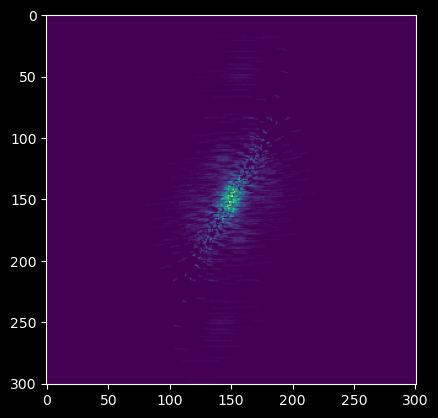

In [28]:
plt.imshow(counts[0])

In [29]:
from supermage.utils.plotting import weighted_dirty_cube_tool, velocity_map
from supermage.utils.doppler_velocities import create_velocity_grid_stable

systemic_velocity = 1245.5
velocities_absolute, _ = create_velocity_grid_stable(freq[0]/1e9, freq[-1]/1e9, len(freq))
velocities = velocities_absolute.numpy() - systemic_velocity

roi_start, roi_end = 0, 502
fov_pixels = roi_end - roi_start
arcseconds_per_pixel = fov_arcseconds/npix

dirty_cube = weighted_dirty_cube_tool(mean_re, mean_im, roi_start, roi_end, std_grid_cube_real=std_re, std_grid_cube_imag=std_im, fft_norm="ortho")
extent = (-1*arcseconds_per_pixel*fov_pixels/2, arcseconds_per_pixel*fov_pixels/2, -1*arcseconds_per_pixel*fov_pixels/2, arcseconds_per_pixel*fov_pixels/2)

In [30]:
from supermage.utils.plotting import smooth_mask
masked_dirty_cube = smooth_mask(dirty_cube, clip = 25)*dirty_cube

RMS of the smoothed cube in mJy/beam: 6355.182175920252
final mask sum 659985


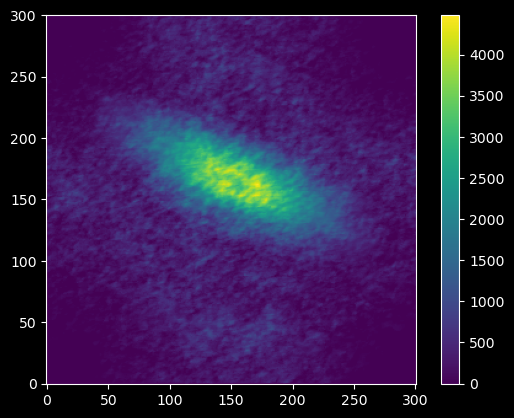

In [31]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors
matplotlib.use("module://matplotlib_inline.backend_inline")
plt.imshow(np.sum(masked_dirty_cube, axis = 2),origin = "lower")
plt.colorbar()
plt.show()

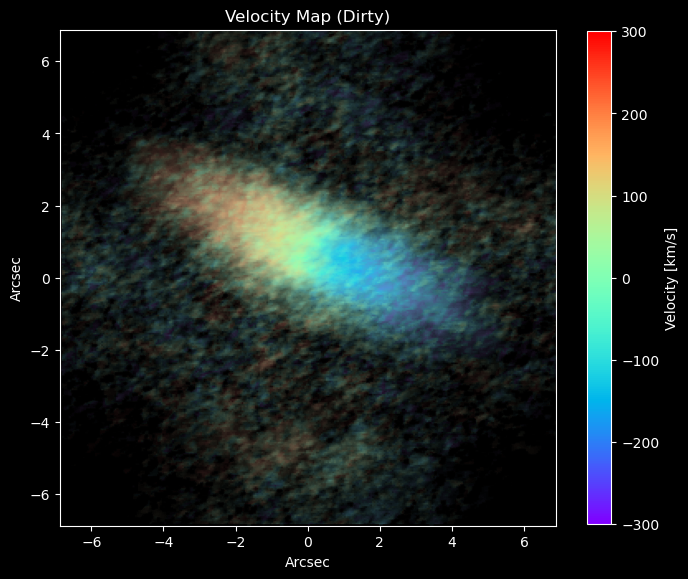

In [32]:
vel_map = velocity_map(masked_dirty_cube, velocities)

plt.style.use('dark_background')
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.set_aspect('equal', adjustable='box')

divnorm=colors.TwoSlopeNorm(vcenter=0., vmin = -300, vmax = 300)
im11 = ax1.imshow(vel_map, cmap = "rainbow", norm = divnorm, origin = "lower",  extent=extent)
c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
c_black= matplotlib.colors.colorConverter.to_rgba('black',alpha = 1)
cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_black, c_white],256)
im12 = ax1.imshow(np.sum(masked_dirty_cube, axis = 2), cmap = cmap_rb, origin = "lower",  extent=extent)

fig.colorbar(im11, label = "Velocity [km/s]", shrink = 0.8)
ax1.set_xlabel("Arcsec")
ax1.set_ylabel("Arcsec")
ax1.set_title("Velocity Map (Dirty)")
#plt.grid(lw = 0.3)
plt.show()

RMS of the smoothed cube in mJy/beam: 6355.182175920252
final mask sum 102774


/home/darthbarth/Code/supermage/supermage/utils/plotting.py:212: RuntimeWarning: invalid value encountered in divide
  vel_map = np.sum(cube * velocities[None, None, :], axis=2) / np.sum(cube, axis=2)


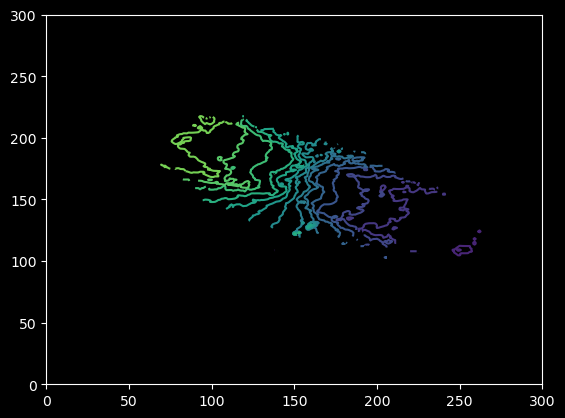

In [33]:
from supermage.utils.plotting import smooth_mask
super_masked_dirty_cube = smooth_mask(dirty_cube, clip = 85)*dirty_cube
vel_map = velocity_map(super_masked_dirty_cube, velocities)
plt.contour(vel_map, levels = np.linspace(-300, 300, 20))

/tmp/ipykernel_4110966/3148919110.py:4: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use("module://matplotlib_inline.backend_inline")


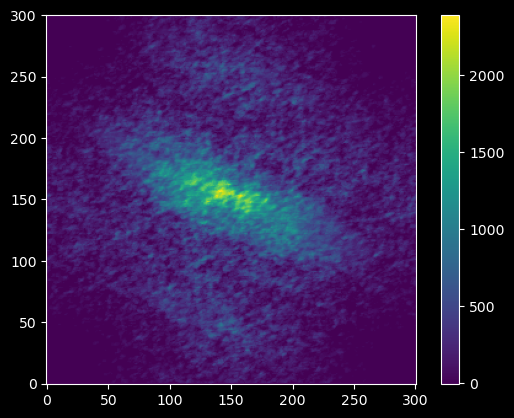

In [39]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors
matplotlib.use("module://matplotlib_inline.backend_inline")
plt.imshow(np.sum(masked_dirty_cube, axis = 2),origin = "lower")
plt.colorbar()
plt.show()

/home/darthbarth/Code/supermage/supermage/utils/plotting.py:212: RuntimeWarning: invalid value encountered in divide
  vel_map = np.sum(cube * velocities[None, None, :], axis=2) / np.sum(cube, axis=2)


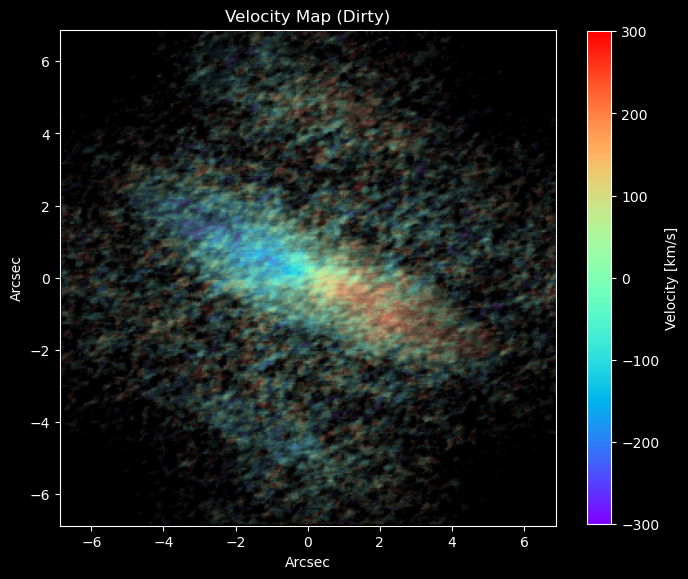

In [40]:
vel_map = velocity_map(masked_dirty_cube, velocities)

plt.style.use('dark_background')
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.set_aspect('equal', adjustable='box')

divnorm=colors.TwoSlopeNorm(vcenter=0., vmin = -300, vmax = 300)
im11 = ax1.imshow(vel_map, cmap = "rainbow", norm = divnorm, origin = "lower",  extent=extent)
c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
c_black= matplotlib.colors.colorConverter.to_rgba('black',alpha = 1)
cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_black, c_white],256)
im12 = ax1.imshow(np.sum(masked_dirty_cube, axis = 2), cmap = cmap_rb, origin = "lower",  extent=extent)

fig.colorbar(im11, label = "Velocity [km/s]", shrink = 0.8)
ax1.set_xlabel("Arcsec")
ax1.set_ylabel("Arcsec")
ax1.set_title("Velocity Map (Dirty)")
#plt.grid(lw = 0.3)
plt.show()

RMS of the smoothed cube in mJy/beam: 5542.45732671001
final mask sum 25834


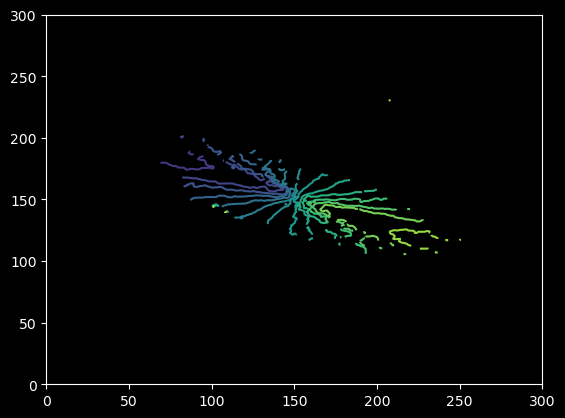

In [43]:
from supermage.utils.plotting import smooth_mask
super_masked_dirty_cube = smooth_mask(dirty_cube, clip = 85)*dirty_cube
vel_map = velocity_map(super_masked_dirty_cube, velocities)
plt.contour(vel_map, levels = np.linspace(-300, 300, 20))

interactive(children=(IntSlider(value=0, description='Channel', max=79), Output()), _dom_classes=('widget-inte…

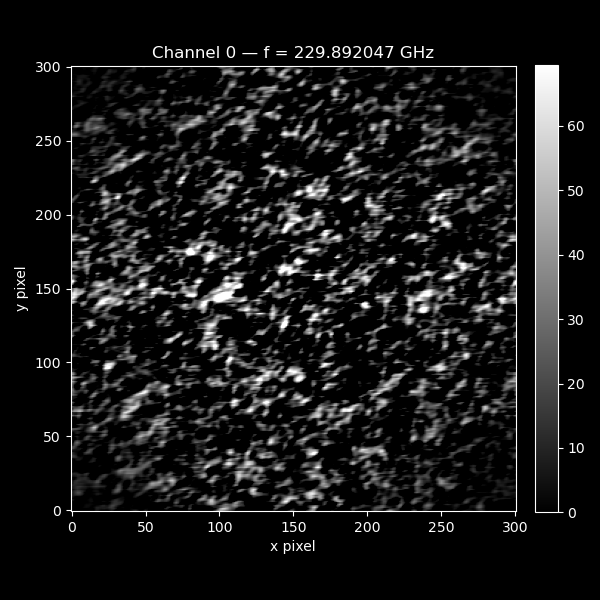

In [44]:
import numpy as np
import matplotlib
matplotlib.use("module://ipympl.backend_nbagg")

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# dirty_cube: (ny, nx, nchan)
nchan = masked_dirty_cube.shape[2]
lo, hi = np.nanpercentile(masked_dirty_cube, [1, 99])  # compute once for stable contrast

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(masked_dirty_cube[:, :, 0], origin="lower", cmap="gray", vmin=lo, vmax=hi)
cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xlabel("x pixel"); ax.set_ylabel("y pixel")
title = ax.set_title("Channel 0")
plt.tight_layout()

def show_channel(idx):
    im.set_data(dirty_cube[:, :, idx])
    # Optional: show frequency if provided
    if 'frequencies' in globals() and frequencies is not None and len(frequencies) == nchan:
        f = frequencies[idx]
        if f > 1e8:  # looks like Hz
            title.set_text(f"Channel {idx} — f = {f/1e9:.6f} GHz")
        else:
            title.set_text(f"Channel {idx} — f = {f:.6f} (units)")
    else:
        title.set_text(f"Channel {idx}")
    fig.canvas.draw_idle()

_ = interact(
    show_channel,
    idx=IntSlider(min=0, max=nchan-1, step=1, value=0, description="Channel"),
)

In [45]:
plt.close('all')

In [25]:
max_uv_coord

3765930.387987173

In [46]:
save_dir1 = "/home/darthbarth/Big_red/NGC4697/ngc4697_high_res/gridded_visibilities_highres_only.npz"
np.savez(
        save_dir1,
        vis_bin_re   = mean_re,
        vis_bin_imag = mean_im,
        std_bin_re   = std_re,
        std_bin_imag = std_im,
        mask         = counts > 0,
        max_uv = np.array([max_uv_coord])
    )

In [ ]:
import numpy as np

def weighted_dirty_cube_tool(
    vis_bin_re_cube, vis_bin_imag_cube,
    roi_start, roi_end,
    std_grid_cube_real=None,
    std_grid_cube_imag=None,
    fft_norm="backward",
    return_snr=False,
    robust=0.0,                 # CASA Briggs robust in [-2, +2]
):
    """
    Build dirty (and optionally SNR) cube from per-cell *means* by
    reweighting with a weight grid (Σw or counts), applying Briggs weighting,
    and using the real part (no Ricean bias).

    Args
    ----
    vis_bin_*_cube : (F, Nu, Nv) arrays of per-cell *mean* visibilities
    std_grid_cube_* : (F, Nu, Nv) arrays with per-cell std (or 1/sqrt(weight));
                      if None, defaults to 1 (i.e., equal natural weights)
    robust : CASA Briggs robust parameter [-2 .. +2]
             ~+2 -> natural, ~-2 -> uniform, 0 -> balanced
    """
    F, Nu, Nv = vis_bin_re_cube.shape
    dirty_cube = []

    # --- Build NATURAL weight grid from provided per-cell std maps ---
    if std_grid_cube_real is None:
        std_grid_cube_real = np.ones_like(vis_bin_re_cube)
    if std_grid_cube_imag is None:
        std_grid_cube_imag = np.ones_like(vis_bin_imag_cube)

    # average real/imag stdev estimates; guard against zeros/nans/infs
    std_averaged = np.nan_to_num(
        np.mean((std_grid_cube_real, std_grid_cube_imag), axis=0),
        nan=0.0, posinf=0.0, neginf=0.0
    )
    # if a cell has no variance info (0), give it effectively zero weight
    std_averaged[np.abs(std_averaged) < 1e-12] = 1e12

    w_nat_cube = 1.0 / (std_averaged ** 2)   # natural weights per uv-cell

    # --- CASA-like Briggs weighting (per-plane) ---
    # Use the common practical form:
    #   w_briggs = w_nat / ( 1 + (f * w_nat / w_mean)^2 )
    # with f = 5 * 10^{-robust}. This approximates CASA behavior:
    #   robust ~ +2 -> w_briggs ≈ w_nat (natural)
    #   robust ~ -2 -> stronger uniformization
    f_scale = 5.0 * (10.0 ** (-float(robust)))

    for i in range(F):
        w_nat = w_nat_cube[i]

        # mean of strictly positive weights to avoid division artifacts
        pos = w_nat > 0
        if np.any(pos):
            w_mean = np.mean(w_nat[pos])
        else:
            w_mean = 1.0

        # Briggs reweighting factor
        t = (f_scale * w_nat / (w_mean if w_mean != 0 else 1.0)) ** 2
        w_briggs = w_nat / (1.0 + t)

        # recover "sum" grid from *mean* vis grid by multiplying by weights
        sum_grid = (vis_bin_re_cube[i] + 1j * vis_bin_imag_cube[i]) * w_briggs

        # inverse FFT to image plane (real part; Hermitian symmetry assumed from gridding)
        img = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sum_grid), norm=fft_norm)).real

        # crop ROI
        img_roi = img[roi_start:roi_end, roi_start:roi_end]
        dirty_cube.append(img_roi)

    dirty_cube = np.stack(dirty_cube, axis=-1)

    if not return_snr:
        return dirty_cube

    # Optional: return a very rough per-pixel SNR cube using
    # sqrt of summed weights as a proxy for inverse noise (per plane).
    snr_cube = []
    for i in range(F):
        w_nat = w_nat_cube[i]
        pos = w_nat > 0
        w_mean = np.mean(w_nat[pos]) if np.any(pos) else 1.0
        t = (f_scale * w_nat / (w_mean if w_mean != 0 else 1.0)) ** 2
        w_briggs = w_nat / (1.0 + t)
        # noise ~ 1/sqrt(sum w), so scale image by sqrt(sum w)
        wsum = np.sum(w_briggs)
        scale = np.sqrt(wsum) if wsum > 0 else 1.0

        # re-create the same dirty-plane (as above) and scale
        sum_grid = (vis_bin_re_cube[i] + 1j * vis_bin_imag_cube[i]) * w_briggs
        img = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sum_grid), norm=fft_norm)).real
        img_roi = img[roi_start:roi_end, roi_start:roi_end] * scale
        snr_cube.append(img_roi)

    snr_cube = np.stack(snr_cube, axis=-1)
    return dirty_cube, snr_cube